In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [22]:
class FCN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

In [23]:
def laplace_residual(model, x):
    x.requires_grad_(True)
    u = model(x)
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    return u_xx + u_yy

In [24]:
# Domain limits
a, b = 1.0, 1.0

# Sample points
def sampler(n_domain, n_boundary):
    # Domain points
    x_domain = torch.rand((n_domain, 1)) * a
    y_domain = torch.rand((n_domain, 1)) * b
    domain_pts = torch.cat([x_domain, y_domain], dim=1)

    # Boundary points
    x = torch.linspace(0, a, n_boundary).reshape(-1, 1)
    y = torch.linspace(0, b, n_boundary).reshape(-1, 1)

    # Boundaries
    left = torch.cat([torch.zeros_like(y), y], dim=1)
    right = torch.cat([a * torch.ones_like(y), y], dim=1)
    bottom = torch.cat([x, torch.zeros_like(x)], dim=1)
    top = torch.cat([x, b * torch.ones_like(x)], dim=1)

    return domain_pts, left, right, bottom, top

In [25]:
# Define f(x) and g(x)
def g(x): return torch.sin(np.pi * x)
def f(x): return torch.zeros_like(x)

# Initialize model
model = FCN([2, 50, 50, 50, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Sample points
n_domain, n_boundary = 5000, 200
domain_pts, left, right, bottom, top = sampler(n_domain, n_boundary)

In [26]:
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Residual loss (PDE)
    r = laplace_residual(model, domain_pts)
    loss_r = torch.mean(r**2)

    # Boundary losses
    u_left = model(left)
    u_right = model(right)
    u_bottom = model(bottom)
    u_top = model(top)

    loss_bc = (
        torch.mean((u_left)**2) +
        torch.mean((u_right)**2) +
        torch.mean((u_bottom - f(bottom[:, 0:1]))**2) +
        torch.mean((u_top - g(top[:, 0:1]))**2)
    )

    # Total loss
    loss = loss_r + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.42445
Epoch 500, Loss: 0.01383
Epoch 1000, Loss: 0.00372
Epoch 1500, Loss: 0.00119
Epoch 2000, Loss: 0.02779
Epoch 2500, Loss: 0.00048
Epoch 3000, Loss: 0.00032
Epoch 3500, Loss: 0.00022
Epoch 4000, Loss: 0.00187
Epoch 4500, Loss: 0.00012


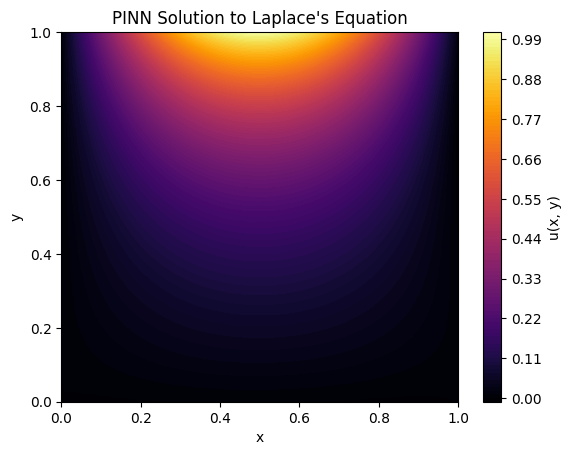

In [27]:
x = torch.linspace(0, a, 100)
y = torch.linspace(0, b, 100)
X, Y = torch.meshgrid(x, y, indexing='ij')
XY = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

with torch.no_grad():
    u_pred = model(XY).reshape(100, 100).numpy()

plt.contourf(X.numpy(), Y.numpy(), u_pred, levels=100, cmap="inferno")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution to Laplace's Equation")
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Domain size
a, b = 1.0, 1.0

# Grid resolution
nx, ny = 100, 100
dx = a / (nx - 1)
dy = b / (ny - 1)

# Grid
x = np.linspace(0, a, nx)
y = np.linspace(0, b, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Boundary condition functions
def f(x): return np.sin(np.pi * x)
def g(x): return np.zeros_like(x)

# Initialize solution
U = np.zeros((nx, ny))

# Apply boundary conditions
U[:, 0] = g(x)        # Bottom
U[:, -1] = f(x)       # Top
U[0, :] = 0           # Left
U[-1, :] = 0          # Right

In [31]:
def solve_laplace(U, tol=1e-5, max_iter=10000):
    U_new = U.copy()
    for it in range(max_iter):
        U_old = U_new.copy()
        U_new[1:-1, 1:-1] = 0.25 * (
            U_old[2:, 1:-1] + U_old[:-2, 1:-1] +
            U_old[1:-1, 2:] + U_old[1:-1, :-2]
        )
        # Re-apply boundary conditions to be safe
        U_new[:, 0] = g(x)
        U_new[:, -1] = f(x)
        U_new[0, :] = 0
        U_new[-1, :] = 0

        diff = np.linalg.norm(U_new - U_old)
        if diff < tol:
            print(f"Converged in {it} iterations.")
            break
    return U_new

U_fd = solve_laplace(U)

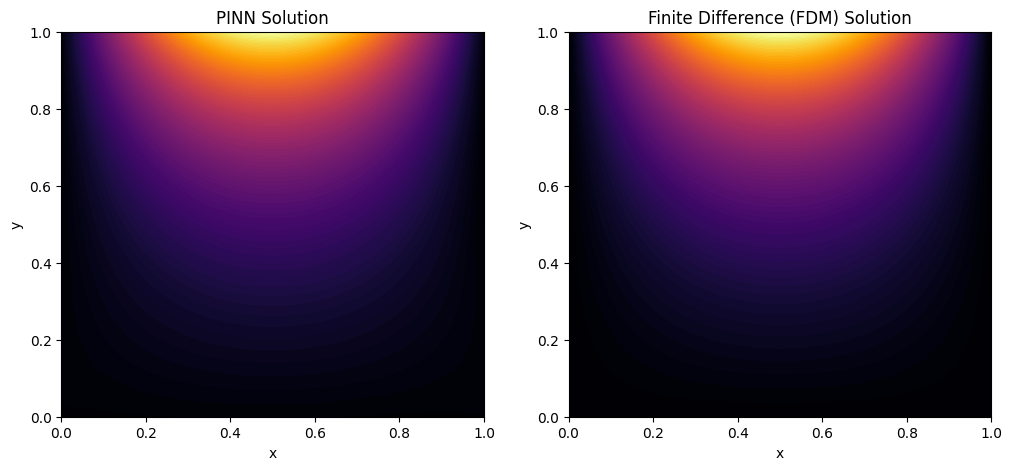

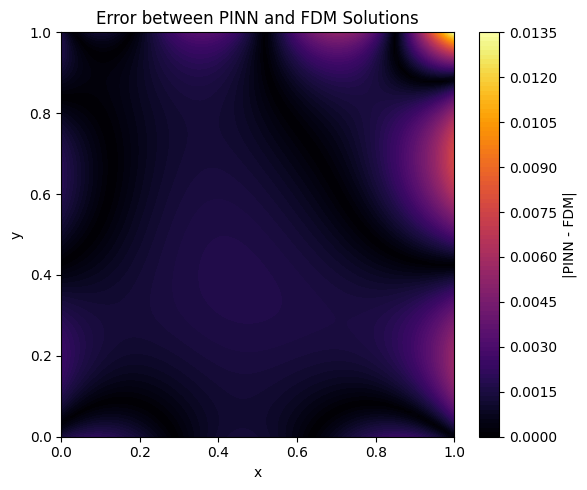

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PINN Solution
axs[0].contourf(X, Y, u_pred, levels=100, cmap="inferno")
axs[0].set_title("PINN Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# FDM Solution
axs[1].contourf(X, Y, U_fd, levels=100, cmap="inferno")
axs[1].set_title("Finite Difference (FDM) Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Error map
error = np.abs(u_pred - U_fd)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, error, levels=100, cmap="inferno")
plt.colorbar(label="|PINN - FDM|")
plt.title("Error between PINN and FDM Solutions")
plt.xlabel("x")
plt.ylabel("y")


plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter


s = "anagram"
t = "nagaram"

Counter({'a': 3, 'n': 1, 'g': 1, 'r': 1, 'm': 1})